In [1]:
# Section 1: Import Libraries and Setup
import pandas as pd
import re
import emoji
import time
import nltk
import string
import os
from datetime import datetime
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configure pandas for better data display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)

# Record start time for performance tracking
start_time = time.time()

# Check if running in a Jupyter environment for progress bars
try:
    from IPython import get_ipython
    is_notebook = 'IPKernelApp' in get_ipython().config
    tqdm.pandas()
except:
    is_notebook = False

# Simple fallback progress function if tqdm is unavailable
def basic_progress(iterable, description="Processing"):
    print(f"{description}...")
    return iterable

# Use tqdm for progress tracking, fallback to basic_progress if unavailable
try:
    from tqdm.notebook import tqdm as tqdm_notebook
    progress_bar = tqdm_notebook if is_notebook else tqdm
except ImportError:
    progress_bar = basic_progress


In [2]:
# Section 2: Data Loading and Initial Inspection
def load_data(file_path):
    """Load dataset from a CSV file and display basic information."""
    print("Loading dataset...")
    try:
        data = pd.read_csv(file_path)
        print(f"✓ Dataset loaded with {len(data)} rows and {len(data.columns)} columns")
        print("\nDataset Overview:")
        print(f"Columns: {data.columns.tolist()}")
        print("\nFirst 3 rows:")
        print(data.head(3))
        return data
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

# Load Gojek app review data
file_path = r"C:\Users\theod\Downloads\UAS_PenalaranKomputer\notebook\GojekAppReview_1.csv"
df_reviews = load_data(file_path)

# Download NLTK stopwords
print("\nDownloading NLTK stopwords...")
try:
    nltk.download('stopwords', quiet=True)
    print("✓ NLTK stopwords downloaded")
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

Loading dataset...
✓ Dataset loaded with 225002 rows and 5 columns

Dataset Overview:
Columns: ['userName', 'content', 'score', 'at', 'appVersion']

First 3 rows:
                  userName  \
0                Yuga Edit   
1                 ff burik   
2  Anisa Suci Rahmayuliani   

                                                                                                                   content  \
0                                                                                                  akun gopay saya di blok   
1                                                                Lambat sekali sekarang ini bosssku apk gojek gk kaya dulu   
2  Kenapa sih dari kemarin sy buka aplikasi gojek malah keluar sendiri terus Saya kasih bintang 2 dulu kalo sudah norma...   

   score                   at appVersion  
0      1  2022-01-21 10:52:12      4.9.3  
1      3  2021-11-30 15:40:38      4.9.3  
2      4  2021-11-29 22:58:12      4.9.3  

✓ NLTK stopwords downloaded


In [3]:
# Section 3: Sentiment Labeling
def assign_sentiment(rating):
    """Assign sentiment labels based on star ratings."""
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    return 'negative'

print("\nAssigning sentiment labels...")
df_reviews['sentiment_label'] = df_reviews['score'].apply(assign_sentiment)

# Display sentiment distribution
print("\nSentiment Distribution:")
sentiment_dist = df_reviews['sentiment_label'].value_counts()
print(sentiment_dist)


Assigning sentiment labels...

Sentiment Distribution:
sentiment_label
positive    161371
negative     54171
neutral       9460
Name: count, dtype: int64


In [4]:
# Section 4: Text Preprocessing
# 4.1 Text Cleaning
def clean_review_text(text):
    """Clean text by removing URLs, punctuation, numbers, and extra spaces."""
    if not isinstance(text, str):
        return ""
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    return text.lower()

In [5]:
# 4.2 Text Normalization
normalization_map = {
    'gk': 'tidak', 'ga': 'tidak', 'ngga': 'tidak', 'nggak': 'tidak', 'tdk': 'tidak',
    'bgt': 'banget', 'dr': 'dari', 'udh': 'sudah', 'jg': 'juga', 'aja': 'saja',
    'sy': 'saya', 'trs': 'terus', 'bkin': 'bikin', 'blm': 'belum', 'sm': 'sama',
    'tp': 'tapi', 'dgn': 'dengan', 'krn': 'karena', 'yg': 'yang', 'utk': 'untuk',
    'klo': 'kalau', 'gw': 'saya', 'gue': 'saya', 'lu': 'kamu', 'kyk': 'seperti',
    'gmn': 'bagaimana', 'sih': 'sih', 'deh': 'deh', 'dpt': 'dapat', 'bs': 'bisa',
    'mantul': 'mantap', 'ntaps': 'mantap'
}

def normalize_review_text(text):
    """Normalize informal Indonesian words using a dictionary."""
    if not isinstance(text, str):
        return ""
    words = text.split()
    return ' '.join(normalization_map.get(word, word) for word in words)

In [6]:
# 4.3 Tokenization and Stopword Removal
indonesian_stopwords = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'dengan', 'pada', 'untuk', 'dari', 'di', 'ke', 'dan', 'atau', 'ini', 'itu'}
indonesian_stopwords.update(custom_stopwords)

def tokenize_and_filter(text):
    """Tokenize text and remove stopwords."""
    if not isinstance(text, str):
        return ""
    tokens = text.split()
    return ' '.join(word for word in tokens if word.lower() not in indonesian_stopwords)

In [7]:
# 4.4 Stemming
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def stem_text_content(text):
    """Apply stemming to reduce words to their root form."""
    if not isinstance(text, str):
        return ""
    return stemmer.stem(text)

# Apply preprocessing steps
print("\nApplying text preprocessing steps...")
df_reviews['cleaned_text'] = df_reviews['content'].progress_apply(clean_review_text) if is_notebook else [clean_review_text(text) for text in progress_bar(df_reviews['content'], "Cleaning text")]
df_reviews['normalized_text'] = df_reviews['cleaned_text'].progress_apply(normalize_review_text) if is_notebook else [normalize_review_text(text) for text in progress_bar(df_reviews['cleaned_text'], "Normalizing text")]
df_reviews['tokenized_text'] = df_reviews['normalized_text'].progress_apply(tokenize_and_filter) if is_notebook else [tokenize_and_filter(text) for text in progress_bar(df_reviews['normalized_text'], "Tokenizing and removing stopwords")]
df_reviews['stemmed_text'] = df_reviews['tokenized_text'].progress_apply(stem_text_content) if is_notebook else [stem_text_content(text) for text in progress_bar(df_reviews['tokenized_text'], "Stemming text")]



Applying text preprocessing steps...


100%|██████████| 225002/225002 [1:53:07<00:00, 33.15it/s]  



Generating visualizations...


C:\Users\theod\AppData\Local\Temp\ipykernel_7860\4291556134.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df_reviews, palette='Set2')


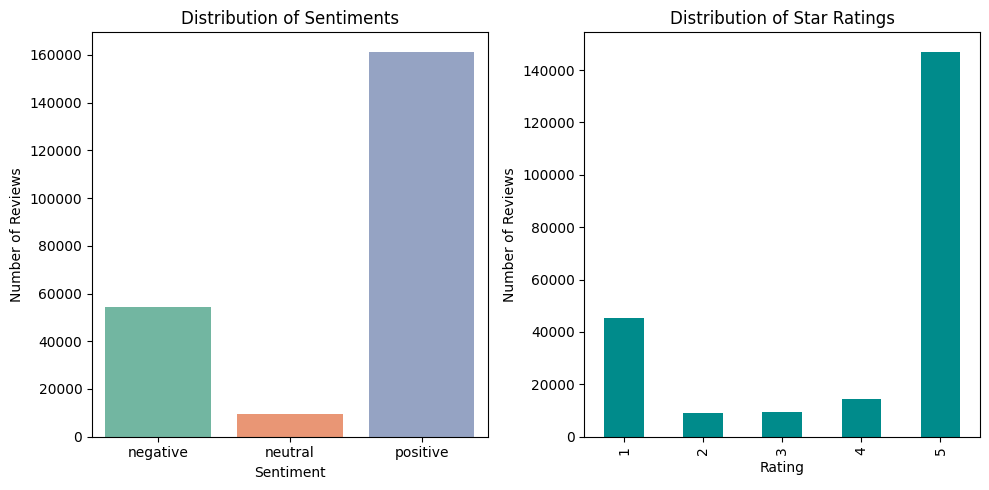

In [8]:
# Section 5: Data Visualization
print("\nGenerating visualizations...")
plt.figure(figsize=(10, 5))

# Sentiment distribution bar plot
plt.subplot(1, 2, 1)
sns.countplot(x='sentiment_label', data=df_reviews, palette='Set2')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

# Rating distribution bar plot
plt.subplot(1, 2, 2)
df_reviews['score'].value_counts().sort_index().plot(kind='bar', color='darkcyan')
plt.title('Distribution of Star Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

plt.tight_layout()
plt.show()


Generating word clouds for each sentiment...


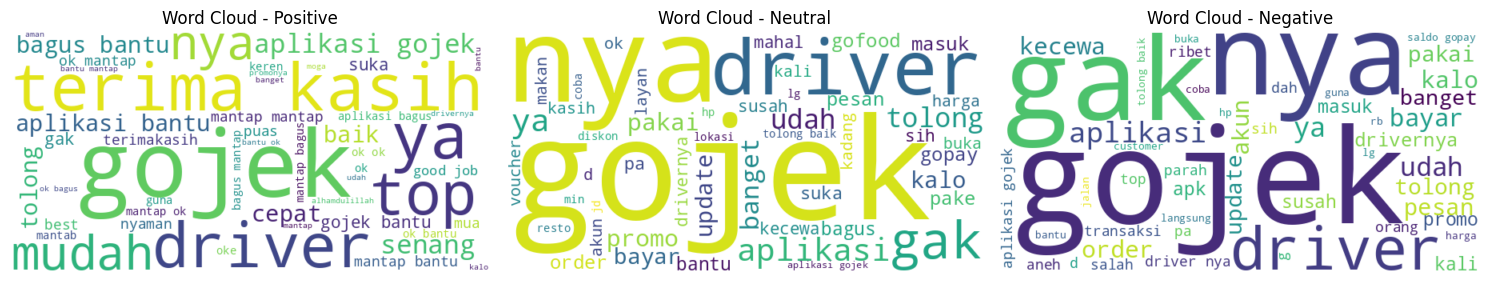

In [15]:
# Word cloud visualization (optional)
try:
    from wordcloud import WordCloud
    print("\nGenerating word clouds for each sentiment...")
    plt.figure(figsize=(15, 5))
    for idx, sentiment in enumerate(['positive', 'neutral', 'negative'], 1):
        plt.subplot(1, 3, idx)
        text = ' '.join(df_reviews[df_reviews['sentiment_label'] == sentiment]['stemmed_text'].dropna())
        if text:
            wordcloud = WordCloud(width=600, height=300, background_color='white', max_words=50).generate(text)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Word Cloud - {sentiment.capitalize()}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("WordCloud module not found. Install it using: pip install wordcloud")

In [10]:
# Section 6: Save Processed Data
def save_processed_data(dataframe, output_dir="data"):
    """Save the processed dataset to CSV files."""
    print("\nSaving processed data...")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"✓ Created '{output_dir}' directory")

    # Define output columns
    output_columns = ['userName', 'content', 'score', 'at', 'appVersion', 'sentiment_label']
    final_data = dataframe[output_columns].copy()

    # Save with timestamp and standard name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    timestamped_path = os.path.join(output_dir, f"GojekAppReview_Processed_{timestamp}.csv")
    standard_path = os.path.join(output_dir, "GojekAppReview_Processed.csv")
    full_path = os.path.join(output_dir, "GojekAppReview_Processed_Full.csv")

    try:
        final_data.to_csv(timestamped_path, index=False)
        print(f"✓ Saved timestamped dataset: {timestamped_path}")
        final_data.to_csv(standard_path, index=False)
        print(f"✓ Saved standard dataset: {standard_path}")
        dataframe.to_csv(full_path, index=False)
        print(f"✓ Saved full dataset with all columns: {full_path}")
    except Exception as e:
        print(f"Error saving dataset: {e}")

In [13]:
# Save the processed dataset
save_processed_data(df_reviews)


Saving processed data...
✓ Saved timestamped dataset: data\GojekAppReview_Processed_20250606_181949.csv
✓ Saved standard dataset: data\GojekAppReview_Processed.csv
✓ Saved full dataset with all columns: data\GojekAppReview_Processed_Full.csv


In [14]:
# Section 7: Final Summary
print("\nFinal Dataset Summary:")
print(f"Total reviews processed: {len(df_reviews)}")
print("Sentiment distribution:", dict(sentiment_dist))
print(f"Processing time: {time.time() - start_time:.2f} seconds")


Final Dataset Summary:
Total reviews processed: 225002
Sentiment distribution: {'positive': 161371, 'negative': 54171, 'neutral': 9460}
Processing time: 9600.30 seconds
